# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [ ]:
# check gpu status
#!nvidia-smi

In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adagrad, Adam

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[128,64]):
    """
    Build your own model
    """
    model=Sequential()
    model.add(Dense(units=input_shape[1], input_dim=input_shape[1],kernel_initializer='normal',activation='relu',name='input'))
    for i, n_units in enumerate(num_neurons):
        model.add(Dense(units=n_units,kernel_initializer='normal',activation='relu',name='hidden'+str(i+1)))
    model.add(Dense(units=output_units,kernel_initializer='normal',activation='softmax',name='output'))
    return model

In [6]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [1e-1,1e-2,1e-3]
EPOCHS = 30
BATCH_SIZE = 256
MOMENTUM = 0.9

def build_opt(opt,lr):
    if opt== 'SGD':
        return SGD(lr=lr, nesterov=True, momentum=True)
    elif opt== 'RMSprop':
        return RMSprop(lr=lr,rho=0.9,epsilon=None,decay=0.0)
    elif opt=='Adagrad':
        return Adagrad(lr=lr,epsilon=None,decay=0.0)
    elif opt== 'Adam':
        return Adam(lr=lr,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)


In [7]:
results = {}
OPTS = ['SGD','RMSprop','Adagrad','Adam']
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for lr in LEARNING_RATE:
    for opt in OPTS:
        keras.backend.clear_session() #把舊的graph清掉
        print(f'Current opt = {opt}, lr={lr}\n')
        
        model = build_mlp(input_shape=x_train.shape)
        model.summary()
        
        optimizer=build_opt(opt,lr)
              
        model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
        
        model.fit(x_train,y_train,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_data=(x_test,y_test),
                  shuffle=True)
              
        # collect results
        train_loss=model.history.history['loss']
        valid_loss=model.history.history['val_loss']
        train_acc =model.history.history['acc']
        valid_acc =model.history.history['val_acc']
        
        # create result dictionary
        exp_name_tag = 'exp_%s'%str(opt)+str('+lr_')+str(lr)
        
        results[exp_name_tag]={'train_loss':train_loss,
                               'valid_loss':valid_loss,
                               'train_acc':train_acc,
                               'valid_acc':valid_acc}

Current opt = SGD, lr=0.1

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden1 (Dense)              (None, 128)               393344    
_________________________________________________________________
hidden2 (Dense)              (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 9,842,506
Trainable params: 9,842,506
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 25s 506us

Epoch 12/30
50000/50000 [==============================] - 35s 697us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 13/30
50000/50000 [==============================] - 35s 699us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 14/30
50000/50000 [==============================] - 35s 695us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 15/30
50000/50000 [==============================] - 35s 696us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 16/30
50000/50000 [==============================] - 35s 700us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 17/30
50000/50000 [==============================] - 35s 699us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 18/30
50000/50000 [==============================] - 35s 697us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 39s 782us/step - loss: 14.4423 - acc: 0.1002 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/30
50000/50000 [==============================] - 38s 769us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/30
50000/50000 [==============================] - 38s 768us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/30
50000/50000 [==============================] - 38s 766us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/30
50000/50000 [==============================] - 38s 762us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/30
50000/50000 [==============================] - 38s 764us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/30
50000/50000 [==============================] - 38s 763us/step - loss: 14.5063 - acc: 0.1000 -

50000/50000 [==============================] - 32s 635us/step - loss: 2.3131 - acc: 0.0970 - val_loss: 2.3121 - val_acc: 0.1000
Epoch 23/30
50000/50000 [==============================] - 31s 628us/step - loss: 2.3125 - acc: 0.0996 - val_loss: 2.3108 - val_acc: 0.1000
Epoch 24/30
50000/50000 [==============================] - 32s 634us/step - loss: 2.3141 - acc: 0.0995 - val_loss: 2.3137 - val_acc: 0.1000
Epoch 25/30
50000/50000 [==============================] - 32s 630us/step - loss: 2.3134 - acc: 0.1016 - val_loss: 2.3094 - val_acc: 0.1000
Epoch 26/30
50000/50000 [==============================] - 32s 631us/step - loss: 2.3116 - acc: 0.1003 - val_loss: 2.3080 - val_acc: 0.1000
Epoch 27/30
50000/50000 [==============================] - 31s 627us/step - loss: 2.3140 - acc: 0.1017 - val_loss: 2.3125 - val_acc: 0.1000
Epoch 28/30
50000/50000 [==============================] - 32s 631us/step - loss: 2.3155 - acc: 0.0998 - val_loss: 2.3113 - val_acc: 0.1000
Epoch 29/30
50000/50000 [=======

50000/50000 [==============================] - 34s 673us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/30
50000/50000 [==============================] - 34s 675us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/30
50000/50000 [==============================] - 34s 673us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 9/30
50000/50000 [==============================] - 34s 672us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/30
50000/50000 [==============================] - 34s 677us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/30
50000/50000 [==============================] - 34s 674us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 12/30
50000/50000 [==============================] - 34s 673us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 13/30
50000/500

50000/50000 [==============================] - 38s 765us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 27/30
50000/50000 [==============================] - 38s 761us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 28/30
50000/50000 [==============================] - 38s 763us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 29/30
50000/50000 [==============================] - 38s 766us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 30/30
50000/50000 [==============================] - 39s 778us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Current opt = SGD, lr=0.001

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden1 (

50000/50000 [==============================] - 35s 705us/step - loss: 1.4841 - acc: 0.4688 - val_loss: 1.6716 - val_acc: 0.4195
Epoch 12/30
50000/50000 [==============================] - 35s 702us/step - loss: 1.4621 - acc: 0.4776 - val_loss: 1.5196 - val_acc: 0.4542
Epoch 13/30
50000/50000 [==============================] - 35s 699us/step - loss: 1.4341 - acc: 0.4872 - val_loss: 1.6071 - val_acc: 0.4277
Epoch 14/30
50000/50000 [==============================] - 35s 701us/step - loss: 1.4150 - acc: 0.4948 - val_loss: 1.6028 - val_acc: 0.4507
Epoch 15/30
50000/50000 [==============================] - 35s 698us/step - loss: 1.3879 - acc: 0.5048 - val_loss: 1.7149 - val_acc: 0.4299
Epoch 16/30
50000/50000 [==============================] - 35s 699us/step - loss: 1.3697 - acc: 0.5090 - val_loss: 1.4980 - val_acc: 0.4766
Epoch 17/30
50000/50000 [==============================] - 35s 699us/step - loss: 1.3458 - acc: 0.5181 - val_loss: 1.6355 - val_acc: 0.4468
Epoch 18/30
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 466s 9ms/step - loss: 1.9794 - acc: 0.2774 - val_loss: 1.7772 - val_acc: 0.3626
Epoch 2/30
50000/50000 [==============================] - 44s 879us/step - loss: 1.7262 - acc: 0.3801 - val_loss: 1.7159 - val_acc: 0.3875
Epoch 3/30
50000/50000 [==============================] - 45s 897us/step - loss: 1.6330 - acc: 0.4165 - val_loss: 1.6104 - val_acc: 0.4191
Epoch 4/30
50000/50000 [==============================] - 44s 878us/step - loss: 1.5764 - acc: 0.4362 - val_loss: 1.5392 - val_acc: 0.4510
Epoch 5/30
50000/50000 [==============================] - 44s 885us/step - loss: 1.5262 - acc: 0.4542 - val_loss: 1.5411 - val_acc: 0.4446
Epoch 6/30
50000/50000 [==============================] - 45s 896us/step - loss: 1.4873 - acc: 0.4681 - val_loss: 1.5454 - val_acc: 0.4376
Epoch 7/30
50000/50000 [==============================] - 45s 899us/step - loss: 1.4530 - acc: 0.4828 - val_loss: 1.5

In [12]:
results.keys()

dict_keys(['exp_SGD+lr_0.1', 'exp_RMSprop+lr_0.1', 'exp_Adagrad+lr_0.1', 'exp_Adam+lr_0.1', 'exp_SGD+lr_0.01', 'exp_RMSprop+lr_0.01', 'exp_Adagrad+lr_0.01', 'exp_Adam+lr_0.01', 'exp_SGD+lr_0.001', 'exp_RMSprop+lr_0.001', 'exp_Adagrad+lr_0.001', 'exp_Adam+lr_0.001'])

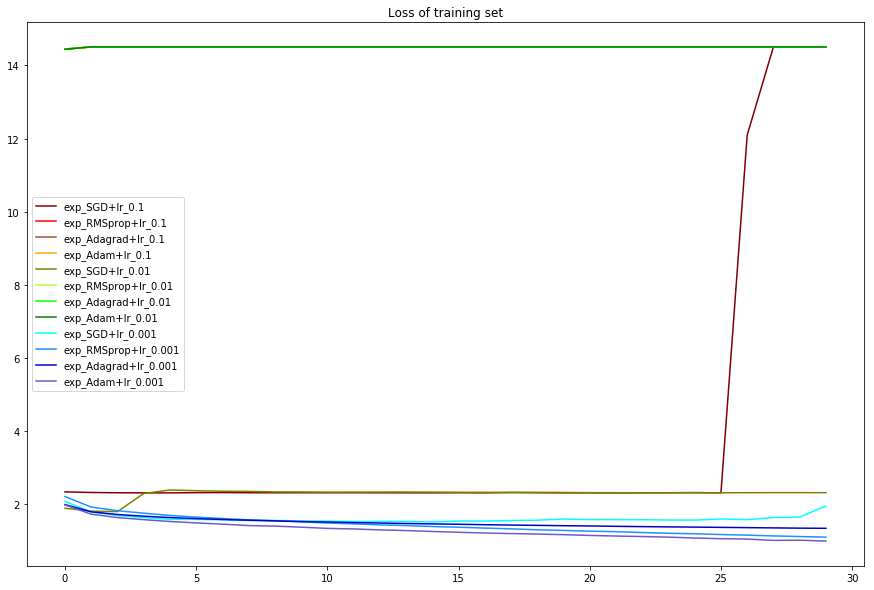

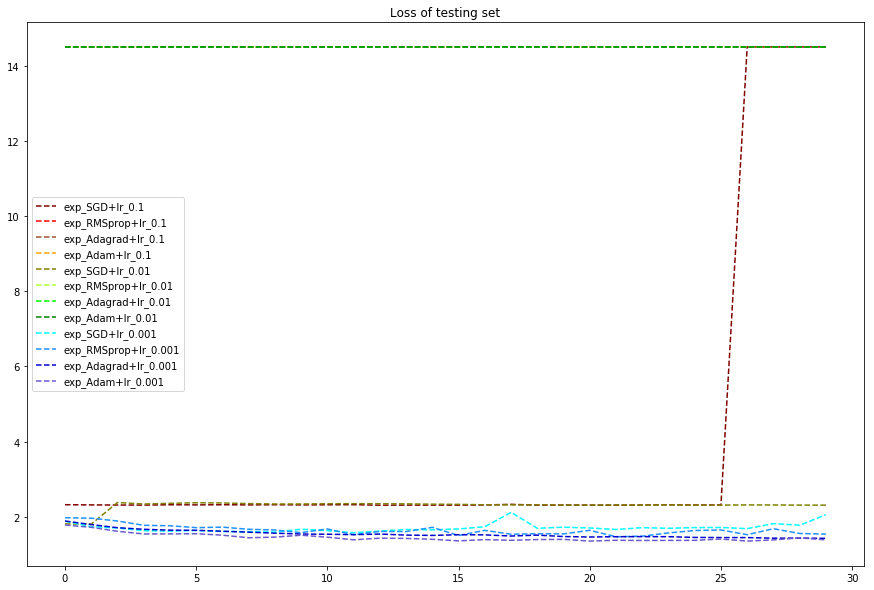

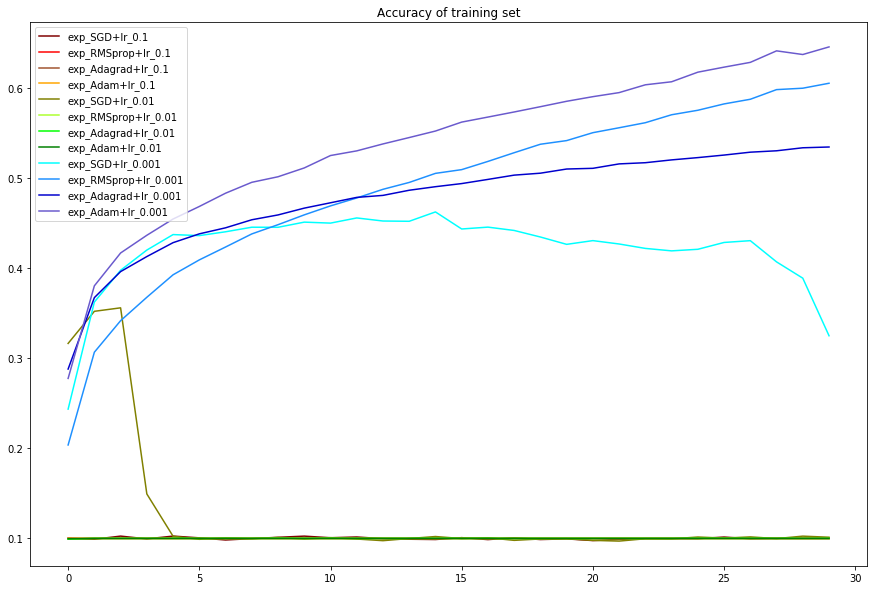

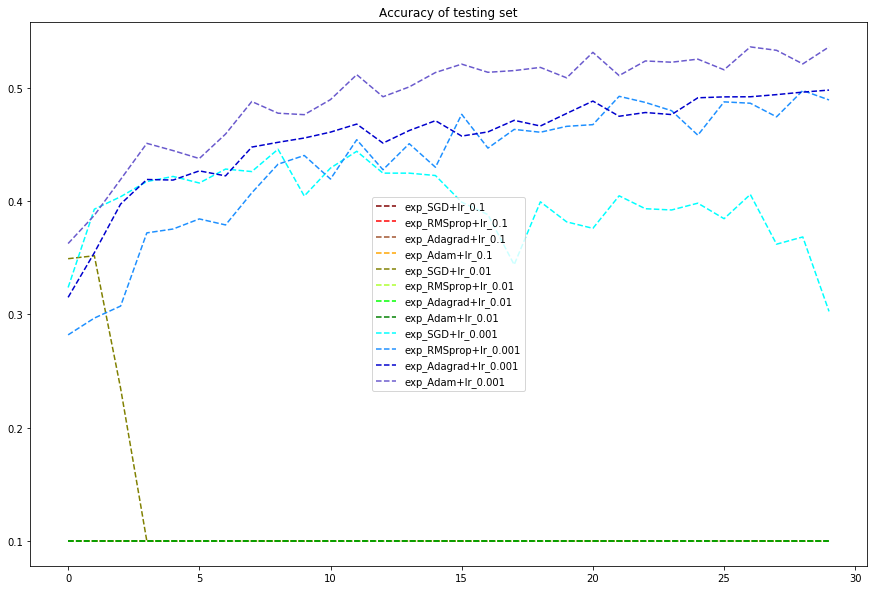

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar=['maroon','red','sienna','orange','olive','greenyellow','lime','green','aqua','dodgerblue','mediumblue','slateblue']
"""
將實驗結果繪出
"""
plt.figure(figsize=(15,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'],'-',label=cond,color=color_bar[i])
plt.title('Loss of training set')
plt.legend()

plt.figure(figsize=(15,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'],'--',label=cond,color=color_bar[i])
plt.title('Loss of testing set')
plt.legend()

plt.figure(figsize=(15,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'],'-',label=cond,color=color_bar[i])
plt.title('Accuracy of training set')
plt.legend()

plt.figure(figsize=(15,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'],'--',label=cond,color=color_bar[i])
plt.title('Accuracy of testing set')
plt.legend()